In [66]:
# 0.0. Importando as libs

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from matplotlib.dates import DateFormatter, AutoDateLocator
from matplotlib.dates import DateFormatter, AutoDateLocator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
#from fbprophet import Prophet
import seaborn as sns
import pandas as pd
import numpy as np
import os

# 0.1. Construindo a path de input e importanto o dataframe

scaler = StandardScaler()
script_path = os.getcwd()
cutting_string = "Scripts"

partes = script_path.split(cutting_string)
path_insumos = partes[0] + "Insumos\\Semi-tratado (v2)"

df = pd.read_excel(path_insumos + "\\Semitratado.xlsx")

# Convertendo a coluna de datas
#df['Data da Coleta'] = pd.to_datetime(df['Data da Coleta'])

In [67]:
# O intervalo de corte de outlier é uma variável que deve ser declarada a fim de agrupar os dados
# de x em x dias para detectar outliers nesse meio. A ideia é, com isso, suavizar a curva a medida
# que aumentamos o intervalo de corte de outlier, levando em conta que quanto maior a amostra, 
# mais discrepâncias serão detectadas.
intervalo_de_corte_outliers = 15

# 1.0. Construindo a função que anula outliers
def anula_outliers(series):
    """
    Substitui valores considerados outliers por NaN em uma série.
    """
    # Calcular o primeiro e terceiro quartis
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    # Calcular o IQR
    IQR = Q3 - Q1
    # Definir limites para considerar um dado como outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Substituir os outliers por NaN
    series[(series < lower_bound) | (series > upper_bound)] = np.nan
    return series

# 1.1. Construindo a função que seleciona as colunas, apaga os outliers e remove nulos
def anula_outliers_colunas_selecionadas(df, colunas, intervalo_de_dias):
    """
    Remove outliers de colunas selecionadas e apaga linhas com valores nulos no DataFrame.
    
    Parâmetros:
    - df (pd.DataFrame): DataFrame de entrada.
    - colunas (list): Lista de colunas a serem processadas.
    - intervalo_de_dias (int): Intervalo de dias para agrupar dados antes de detectar outliers.
    
    Retorno:
    - pd.DataFrame: DataFrame com outliers substituídos por NaN e linhas nulas removidas.
    """
    # Garantir que a coluna 'Data da Coleta' está no DataFrame e em formato datetime
    if 'Data da Coleta' not in df.columns:
        raise ValueError("A coluna 'Data da Coleta' deve estar presente no DataFrame.")
    
    df['Data da Coleta'] = pd.to_datetime(df['Data da Coleta'], format='%Y%m%d')
    
    # Filtrar as colunas desejadas junto com 'Data da Coleta'
    colunas_modificadas = colunas.copy()
    if 'Data da Coleta' not in colunas_modificadas:
        colunas_modificadas.append('Data da Coleta')
    
    temp_df = df[colunas_modificadas].copy()
    temp_df.set_index('Data da Coleta', inplace=True)
    
    # Agrupar dados por intervalo de dias e aplicar a função para substituir outliers por NaN
    temp_df = temp_df.resample(f'{intervalo_de_dias}D').apply(lambda group: group.apply(anula_outliers))
    
    # Remover linhas com valores nulos em qualquer coluna
    temp_df.dropna(inplace=True)
    
    # Resetar o índice para voltar 'Data da Coleta' como uma coluna
    temp_df.reset_index(inplace=True)
    
    # Converter 'Data da Coleta' para o formato aaaammdd como int
    temp_df['Data da Coleta'] = temp_df['Data da Coleta'].dt.strftime('%Y%m%d').astype(int)
    
    # Retornar apenas as colunas originalmente solicitadas
    if 'Data da Coleta' not in colunas:
        temp_df = temp_df[colunas]
    
    return temp_df

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 771
[LightGBM] [Info] Number of data points in the train set: 584, number of used features: 4
[LightGBM] [Info] Start training from score 5.490166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

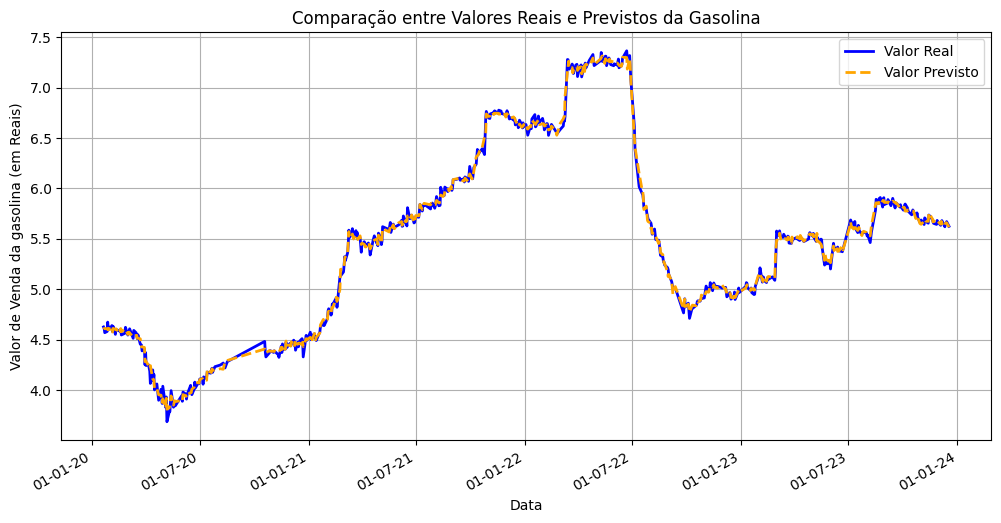

MAE: 0.03
RMSE: 0.04
MAPE: 0.49%


In [68]:
# Definição de colunas para análise
features = ['Data da Coleta', 
            'Volume de transações EXXON (Em milhares)', 
            'Fechamento ARAMCO (em Riyais)', 
            'Fechamento CHEVRON (em Reais)']
target_column = 'Valor de Venda Gasolina (p/L)'

# Remoção de outliers das colunas selecionadas
filtered_df = anula_outliers_colunas_selecionadas(
    df, features + [target_column], intervalo_de_corte_outliers
)

# Garantir que os dados estejam ordenados por data
filtered_df = filtered_df.sort_index()

# Separação entre features (X) e target (y)
X = filtered_df[features]
y = filtered_df[target_column]

# Separação dos dados em treino (todo o dataset é usado para treino neste caso)
X_train = X
y_train = y

# Configuração e treinamento do modelo LightGBM
model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Previsões para todo o conjunto de dados
y_pred = model.predict(X)

# Criação de um DataFrame com valores reais e previstos
result_df = pd.DataFrame({
    'Data': pd.to_datetime(X['Data da Coleta'], format='%Y%m%d'),
    'Target Real': y,
    'Target Previsto': y_pred
})

# Plotagem da comparação entre valores reais e previstos
plt.figure(figsize=(12, 6))
plt.plot(result_df['Data'], result_df['Target Real'], label='Valor Real', color='blue', linewidth=2)
plt.plot(result_df['Data'], result_df['Target Previsto'], label='Valor Previsto', color='orange', linestyle='dashed', linewidth=2)

# Configuração do eixo x para mostrar datas corretamente
ax = plt.gca()
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d-%m-%y'))
plt.gcf().autofmt_xdate()  # Formatar automaticamente as datas para evitar sobreposição

# Configurações adicionais do gráfico
plt.xlabel('Data')
plt.ylabel('Valor de Venda da gasolina (em Reais)')
plt.title('Comparação entre Valores Reais e Previstos da Gasolina')
plt.legend()
plt.grid()
plt.show()

# MAE
mae = mean_absolute_error(y, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))

# MAPE
mape = mean_absolute_percentage_error(y, y_pred)

# Exibição dos resultados
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape * 100:.2f}%")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 621, number of used features: 3
[LightGBM] [Info] Start training from score 4.172036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

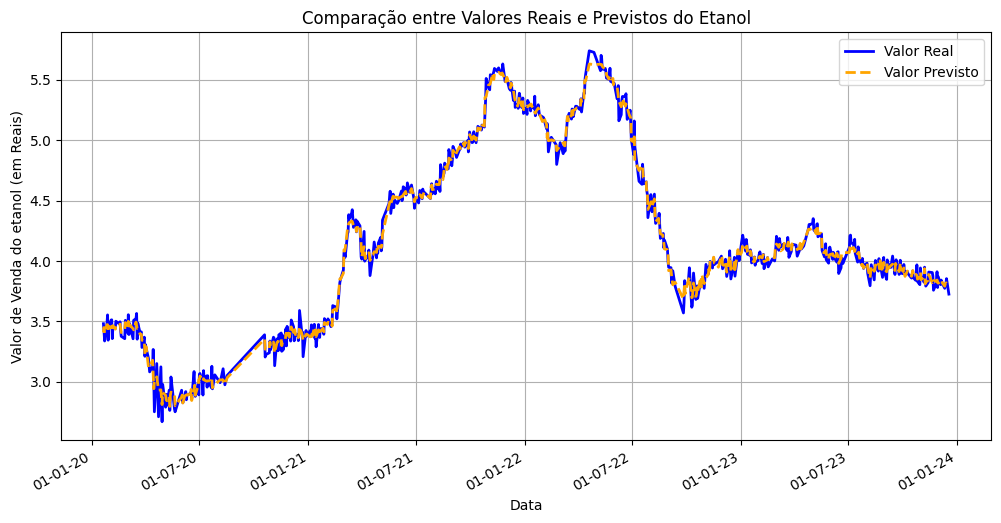

MAE: 0.04
RMSE: 0.05
MAPE: 0.99%


In [69]:
# Definição de colunas para análise
features = ['Data da Coleta', 
            'Volume de transações EXXON (Em milhares)', 
            'Fechamento ARAMCO (em Riyais)']
target_column = 'Valor de Venda Etanol (p/L)'

# Remoção de outliers das colunas selecionadas
filtered_df = anula_outliers_colunas_selecionadas(
    df, features + [target_column], intervalo_de_corte_outliers
)

# Garantir que os dados estejam ordenados por data
filtered_df = filtered_df.sort_index()

# Separação entre features (X) e target (y)
X = filtered_df[features]
y = filtered_df[target_column]

# Separação dos dados em treino (todo o dataset é usado para treino neste caso)
X_train = X
y_train = y

# Configuração e treinamento do modelo LightGBM
model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Previsões para todo o conjunto de dados
y_pred = model.predict(X)

# Criação de um DataFrame com valores reais e previstos
result_df = pd.DataFrame({
    'Data': pd.to_datetime(X['Data da Coleta'], format='%Y%m%d'),
    'Target Real': y,
    'Target Previsto': y_pred
})

# Plotagem da comparação entre valores reais e previstos
plt.figure(figsize=(12, 6))
plt.plot(result_df['Data'], result_df['Target Real'], label='Valor Real', color='blue', linewidth=2)
plt.plot(result_df['Data'], result_df['Target Previsto'], label='Valor Previsto', color='orange', linestyle='dashed', linewidth=2)

# Configuração do eixo x para mostrar datas corretamente
ax = plt.gca()
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d-%m-%y'))
plt.gcf().autofmt_xdate()  # Formatar automaticamente as datas para evitar sobreposição

# Configurações adicionais do gráfico
plt.xlabel('Data')
plt.ylabel('Valor de Venda do etanol (em Reais)')
plt.title('Comparação entre Valores Reais e Previstos do Etanol')
plt.legend()
plt.grid()
plt.show()

# MAE
mae = mean_absolute_error(y, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))

# MAPE
mape = mean_absolute_percentage_error(y, y_pred)

# Exibição dos resultados
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape * 100:.2f}%")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 5
[LightGBM] [Info] Start training from score 5.175933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

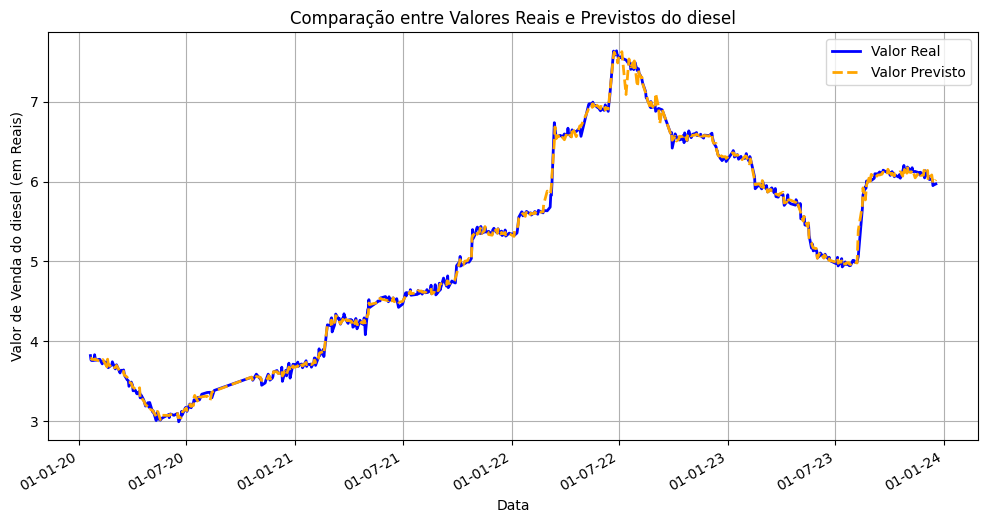

MAE: 0.03
RMSE: 0.05
MAPE: 0.60%


In [70]:
# Definição de colunas para análise
features = ['Data da Coleta', 
            'Volume de transações EXXON (Em milhares)', 
            'Fechamento ARAMCO (em Riyais)', 
            'Fechamento CHEVRON (em Reais)',
            'Fechamento EXXON (em Reais)']
target_column = 'Valor de Venda Diesel (p/L)'

# Remoção de outliers das colunas selecionadas
filtered_df = anula_outliers_colunas_selecionadas(
    df, features + [target_column], intervalo_de_corte_outliers
)

# Garantir que os dados estejam ordenados por data
filtered_df = filtered_df.sort_index()

# Separação entre features (X) e target (y)
X = filtered_df[features]
y = filtered_df[target_column]

# Separação dos dados em treino (todo o dataset é usado para treino neste caso)
X_train = X
y_train = y

# Configuração e treinamento do modelo LightGBM
model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Previsões para todo o conjunto de dados
y_pred = model.predict(X)

# Criação de um DataFrame com valores reais e previstos
result_df = pd.DataFrame({
    'Data': pd.to_datetime(X['Data da Coleta'], format='%Y%m%d'),
    'Target Real': y,
    'Target Previsto': y_pred
})

# Plotagem da comparação entre valores reais e previstos
plt.figure(figsize=(12, 6))
plt.plot(result_df['Data'], result_df['Target Real'], label='Valor Real', color='blue', linewidth=2)
plt.plot(result_df['Data'], result_df['Target Previsto'], label='Valor Previsto', color='orange', linestyle='dashed', linewidth=2)

# Configuração do eixo x para mostrar datas corretamente
ax = plt.gca()
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d-%m-%y'))
plt.gcf().autofmt_xdate()  # Formatar automaticamente as datas para evitar sobreposição

# Configurações adicionais do gráfico
plt.xlabel('Data')
plt.ylabel('Valor de Venda do diesel (em Reais)')
plt.title('Comparação entre Valores Reais e Previstos do diesel')
plt.legend()
plt.grid()
plt.show()

# MAE
mae = mean_absolute_error(y, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))

# MAPE
mape = mean_absolute_percentage_error(y, y_pred)

# Exibição dos resultados
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape * 100:.2f}%")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 944
[LightGBM] [Info] Number of data points in the train set: 564, number of used features: 5
[LightGBM] [Info] Start training from score 95.955989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

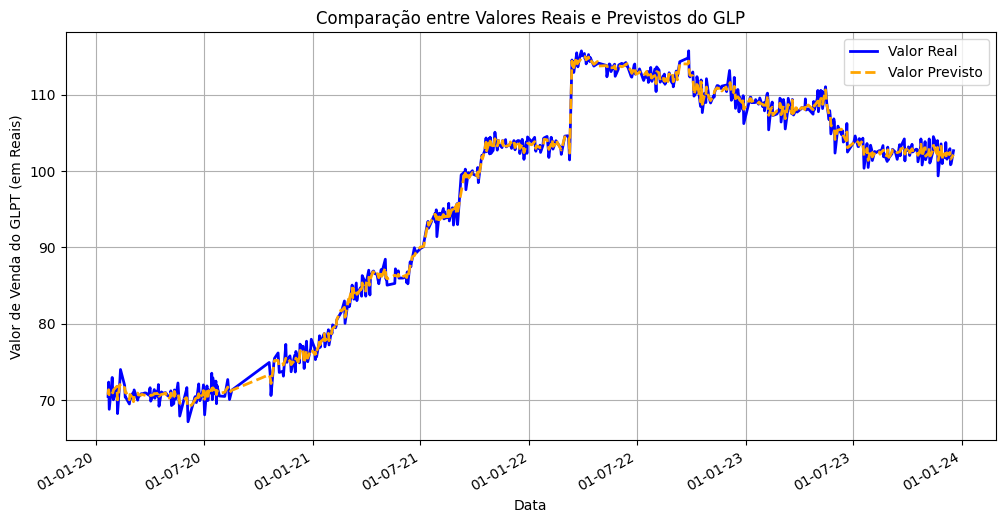

MAE: 0.53
RMSE: 0.69
MAPE: 0.58%


In [71]:
# Definição de colunas para análise
features = ['Data da Coleta', 
            'Volume de transações EXXON (Em milhares)', 
            'Fechamento ARAMCO (em Riyais)', 
            'Fechamento CHEVRON (em Reais)',
            'Fechamento EXXON (em Reais)']
target_column = 'Valor de Venda GLP (p/13kg)'

# Remoção de outliers das colunas selecionadas
filtered_df = anula_outliers_colunas_selecionadas(
    df, features + [target_column], intervalo_de_corte_outliers
)

# Garantir que os dados estejam ordenados por data
filtered_df = filtered_df.sort_index()

# Separação entre features (X) e target (y)
X = filtered_df[features]
y = filtered_df[target_column]

# Separação dos dados em treino (todo o dataset é usado para treino neste caso)
X_train = X
y_train = y

# Configuração e treinamento do modelo LightGBM
model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Previsões para todo o conjunto de dados
y_pred = model.predict(X)

# Criação de um DataFrame com valores reais e previstos
result_df = pd.DataFrame({
    'Data': pd.to_datetime(X['Data da Coleta'], format='%Y%m%d'),
    'Target Real': y,
    'Target Previsto': y_pred
})

# Plotagem da comparação entre valores reais e previstos
plt.figure(figsize=(12, 6))
plt.plot(result_df['Data'], result_df['Target Real'], label='Valor Real', color='blue', linewidth=2)
plt.plot(result_df['Data'], result_df['Target Previsto'], label='Valor Previsto', color='orange', linestyle='dashed', linewidth=2)

# Configuração do eixo x para mostrar datas corretamente
ax = plt.gca()
ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%d-%m-%y'))
plt.gcf().autofmt_xdate()  # Formatar automaticamente as datas para evitar sobreposição

# Configurações adicionais do gráfico
plt.xlabel('Data')
plt.ylabel('Valor de Venda do GLPT (em Reais)')
plt.title('Comparação entre Valores Reais e Previstos do GLP')
plt.legend()
plt.grid()
plt.show()

# MAE
mae = mean_absolute_error(y, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))

# MAPE
mape = mean_absolute_percentage_error(y, y_pred)

# Exibição dos resultados
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape * 100:.2f}%")